In [1]:
import os
import cv2
import glob
import json
import time
import torch
import random
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
#from progressbar import * #进度条
from tqdm import tqdm #进度条
from torchnet import meter
from natsort import natsorted
import matplotlib.pyplot as plt
import torch.nn.functional as F #torch是关于运算的包
from collections import defaultdict
from torch.autograd import Variable
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as T
from torchvision import datasets,transforms, models #torchvision则是打包了一些数据集
#from sklearn.cross_validation import train_test_split
os.environ['CUDA_VISIBLE_DEVICES']='3'

In [2]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transforms=None):
        self.imageFolderDataset = imageFolderDataset
        self.transforms = transforms
        #数据增强
        if transforms is None:
            normalize = T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
            #训练集用数据增强
            self.transforms = T.Compose([
                #T.RandomCrop(224, padding=4),  #先四周填充0，在吧图像随机裁剪成32*32`，
                T.Resize(40),
                T.RandomResizedCrop(32),
                T.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
                #T.RandomVerticalFlip(),
                T.Grayscale(3),
                T.ToTensor(),
                normalize 
            ])
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        # we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        #img0 = img0.convert("L")#转化为灰度
        #img1 = img1.convert("L")
        img0 = self.transforms(img0)
        img1 = self.transforms(img1)
        '''
        if self.should_invert:#是否进行像素反转操作，即0变1， 1变0
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.imageOps.invert(img1)
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        '''
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [3]:
#folder_dataset = datasets.ImageFolder('./data/train_aug_10')
#folder_dataset = datasets.ImageFolder('./data/net_classes')
folder_dataset = datasets.ImageFolder('/home/lhw/kaggle/cifar_10/data/new_train')#在cifar10数据集上做测试

In [4]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset)
print(len(siamese_dataset))

50000


In [5]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


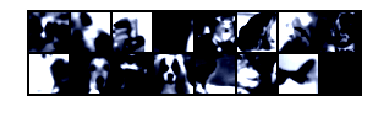

[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]


Process Process-1:
Process Process-3:
Process Process-2:
Process Process-5:
Process Process-8:
Process Process-6:
Process Process-7:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lhw/

  File "/home/lhw/anaconda3/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/lhw/anaconda3/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
KeyboardInterrupt
  File "/home/lhw/anaconda3/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt


In [6]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),            
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [8]:
class wide_basic(nn.Module):
    def __init__(self, in_planes, out_planes, dropout_rate, stride=1):
        super(wide_basic, self).__init__()
        self.left = nn.Sequential(
            nn.BatchNorm2d(in_planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=2, bias=True),
            nn.Dropout(p=dropout_rate),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=True)
        )
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=True))
    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        #out = self.left(x)
        out += self.shortcut(x)
        
        return out

In [9]:
class SiameseNetwork_Wide_ResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, out_size=128):
        super(SiameseNetwork_Wide_ResNet, self).__init__()
        self.in_planes = 16
        assert ((depth-2)%6 == 0), 'Wide-resnet depth should be 6n+2'
        n = int((depth-2)/6)
        k = widen_factor
        print('| Wide-Resnet %dx%d' % (n, k))
        n_stages = [16, 16*k, 32*k, 64*k]
        self.conv1 = nn.Conv2d(3, n_stages[0], kernel_size=3, stride=1, padding=1, bias=True)
        self.layer1 = self._wide_layer(wide_basic, n_stages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(wide_basic, n_stages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(wide_basic, n_stages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(n_stages[3], momentum=0.9)
        self.linear = nn.Linear(n_stages[3], out_size)
    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        #print(num_blocks)
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    def forward_once(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [10]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [11]:
#训练参数
batch_size = 64
lr = 0.0001
lr_decay = 0.995
weight_decay = 1e-4
#epochs = 300
train_number_epochs = 800
model_path = 'model/siamesenetwork_wide_resnet.ckpt'
min_loss = 10000
pre_epoch = 0
max_interval_epoch = 10
pre_train_loss = 10000

In [12]:
train_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=batch_size)
net = SiameseNetwork_Wide_ResNet(26, 10, 0.3, 10)
if os.path.exists(model_path):
    net = torch.load(model_path)
net = net.cuda()
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(),lr = lr)
counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0, train_number_epochs):
    train_loss = 0
    train_count = 0
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        train_count += img1.size(0)
        train_loss += loss_contrastive.data[0]
   
    train_loss /= train_count
    print("Epoch number {} Current loss {}".format(epoch,train_loss))
    counter.append(epoch)
    loss_history.append(train_loss)
    #保存模型
    if min_loss > train_loss:
        min_loss = train_loss
        pre_epoch = epoch
        torch.save(net, model_path)#保存整个神经网络的的结构信息和模型参数信息，save的对象是网络net
    #if epoch - pre_epoch > max_interval_epoch:
    #    print('early stop')
    #    break
    #如果损失不载下降，则降低学习率
    if train_loss > pre_train_loss:
        lr = lr*lr_decay
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    pre_train_loss = train_loss
show_plot(counter,loss_history)

| Wide-Resnet 4x10


/home/lhw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch number 0 Current loss 0.015864819288253784


/home/lhw/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseNetwork_Wide_ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/lhw/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type wide_basic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch number 1 Current loss 0.01583039201796055
Epoch number 2 Current loss 0.015880009159445763
Epoch number 3 Current loss 0.015883497893810272
Epoch number 4 Current loss 0.015879249200224876
Epoch number 5 Current loss 0.015874212607741356
Epoch number 6 Current loss 0.015853315591812134
Epoch number 7 Current loss 0.015897111967206
Epoch number 8 Current loss 0.015873117372393608
Epoch number 9 Current loss 0.015909746289253235
Epoch number 10 Current loss 0.015863120555877686
Epoch number 11 Current loss 0.01587560586631298
Epoch number 12 Current loss 0.015860024839639664
Epoch number 13 Current loss 0.01587848924100399
Epoch number 14 Current loss 0.015873316675424576
Epoch number 15 Current loss 0.015903281047940254
Epoch number 16 Current loss 0.015854982659220695
Epoch number 17 Current loss 0.01588854193687439
Epoch number 18 Current loss 0.015866287052631378
Epoch number 19 Current loss 0.015857107937335968
Epoch number 20 Current loss 0.015863729640841484
Epoch number 21 

Epoch number 165 Current loss 0.01586543582379818
Epoch number 166 Current loss 0.01585533656179905
Epoch number 167 Current loss 0.01586875505745411
Epoch number 168 Current loss 0.015856483951210976
Epoch number 169 Current loss 0.015825610607862473
Epoch number 170 Current loss 0.015855448320508003
Epoch number 171 Current loss 0.015838637948036194
Epoch number 172 Current loss 0.015840278938412666
Epoch number 173 Current loss 0.015851091593503952
Epoch number 174 Current loss 0.015846794471144676
Epoch number 175 Current loss 0.015804249793291092
Epoch number 176 Current loss 0.01583695039153099
Epoch number 177 Current loss 0.01585986837744713
Epoch number 178 Current loss 0.01584501378238201
Epoch number 179 Current loss 0.015815837308764458
Epoch number 180 Current loss 0.015825165435671806


Process Process-1464:
Process Process-1462:
Process Process-1457:
Process Process-1461:
Process Process-1463:
Process Process-1458:
Process Process-1459:
Process Process-1460:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/home/lhw/anaconda3/lib/python

  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)


Traceback (most recent call last):
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-23b0aeaeae64>", line 20, in <module>
    loss_contrastive = criterion(output1,output2,label)
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py", line 477, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-10-a81288ee8f78>", line 14, in forward
    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of t

KeyboardInterrupt: 

In [ ]:
test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)
net = torch.load(model_path)
net = net.cuda()
for i in range(10):
    x0,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    print(label2.numpy())
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0]))